Spectral Overlap Analysis - Full vs Informative Regions
Loaded wavenumber axis: 225 points
Range: 1525.8 - 1749.8 cm⁻¹
Loaded proportions array: (5000, 4)
\nAnalyzing overlaps for all isotopes...
\nProcessing G5+...
  Informative range: 1569.8 - 1604.8 cm⁻¹
  Full spectrum overlaps: ['0.008', '0.007', '0.002', '0.002', '0.002', '0.007']
  Informative overlaps: ['0.080', '0.094', '0.001', '0.000', '0.000', '0.086']
\nProcessing G5+G3...
  Informative range: 1572.8 - 1605.8 cm⁻¹
  Full spectrum overlaps: ['0.010', '0.009', '0.003', '0.004', '0.003', '0.009']
  Informative overlaps: ['0.022', '0.022', '0.001', '0.001', '0.001', '0.022']
\nProcessing V1...
  Informative range: 1533.8 - 1588.8 cm⁻¹
  Full spectrum overlaps: ['0.009', '0.006', '0.005', '0.005', '0.005', '0.007']
  Informative overlaps: ['0.008', '0.013', '0.110', '0.099', '0.103', '0.009']
\nProcessing V4...
  Informative range: 1572.8 - 1584.8 cm⁻¹
  Full spectrum overlaps: ['0.010', '0.008', '0.005', '0.006', '0.005', '0.0

/home/ianjefab/ipykernel_471640/839534442.py:322: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 0.98])


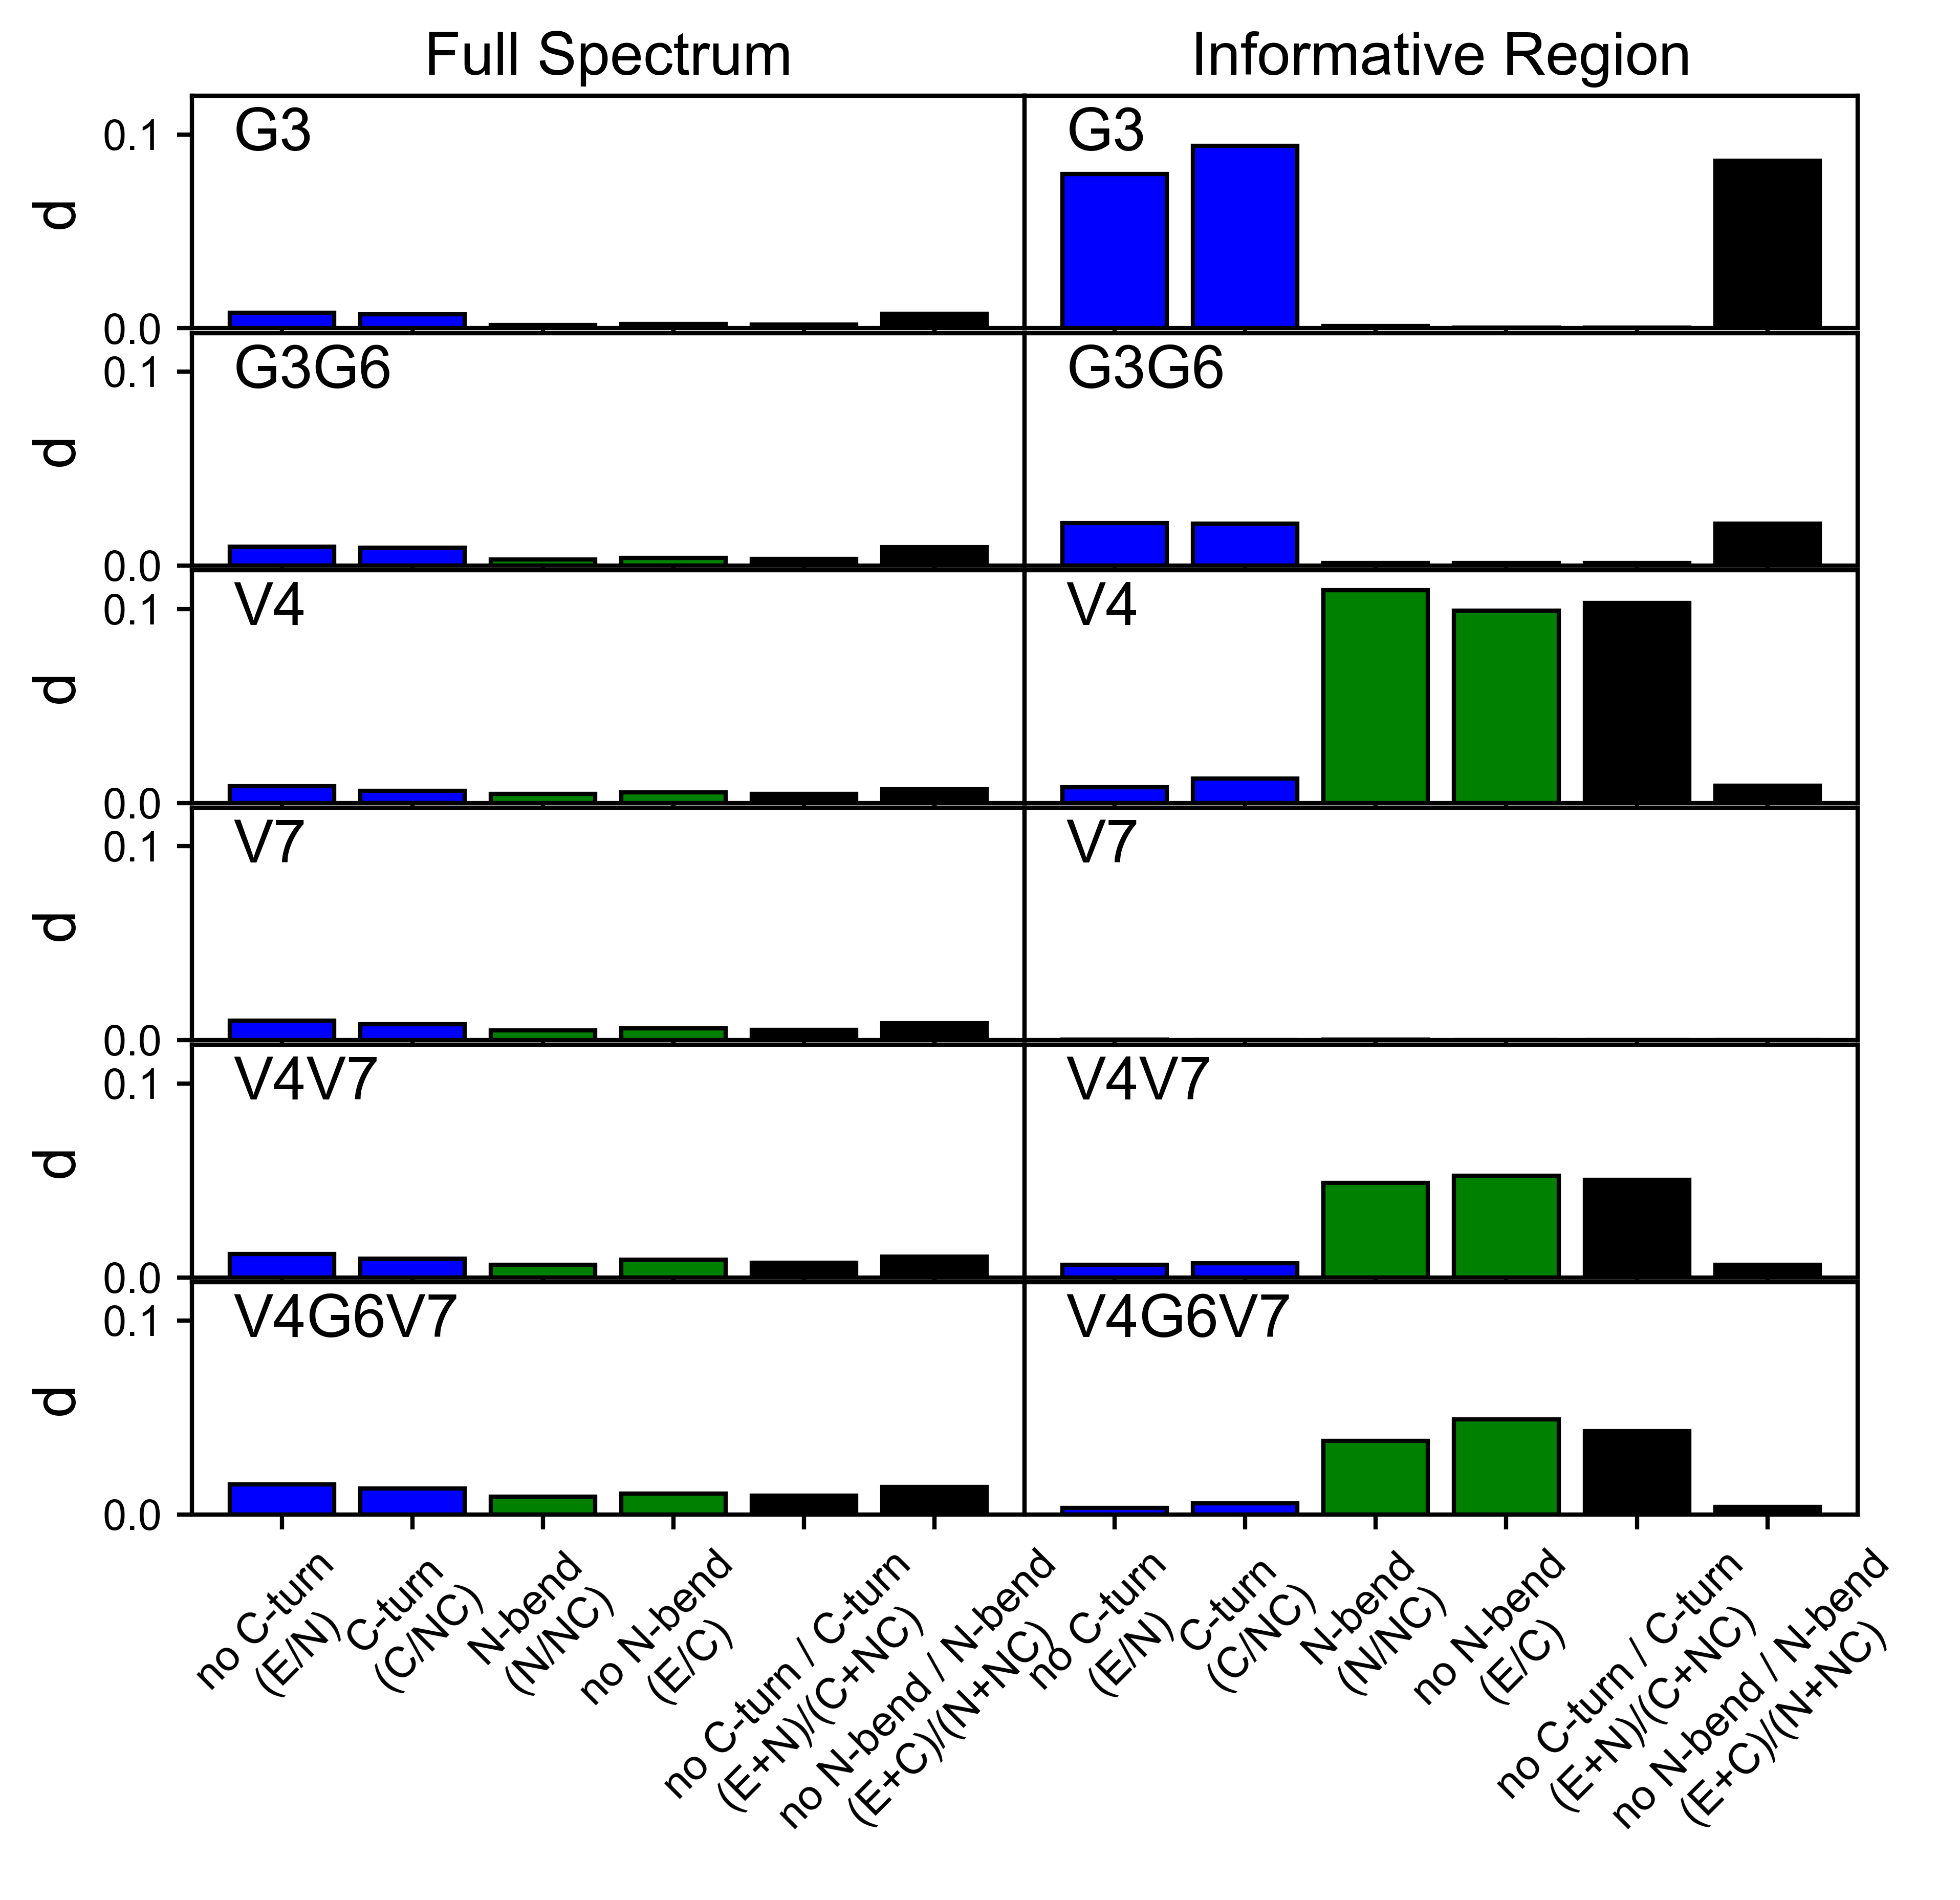

\nSpectral overlap analysis completed successfully!


In [1]:
### DISTINGUISHABILITY BETWEEN STATE SPECTRA WITH FULL SPECTRA AND INFORMATIVE REGIONS (FIG S16) ###
### 2 Aug 2025 ###

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# -----------------------------------------------------------------------------
# CONFIGURATION
# -----------------------------------------------------------------------------

# Paths
BASE_DIR = Path('../data')
WAVENUMBERS_FILE = BASE_DIR / 'waxis.txt'
SIM_DIR = BASE_DIR / 'sim_data' / 'sim_spec'
PROP_DIR = BASE_DIR / 'prop_array'

# Data Specifications
ISOTOPES = ['G5+', 'G5+G3', 'V1', 'V4', 'V1V4', 'V1G3V4']
ISOTOPE_LABELS = {
    'G5+': 'G3', 'G5+G3': 'G3G6', 'V1': 'V4', 'V4': 'V7',
    'V1V4': 'V4V7', 'V1G3V4': 'V4G6V7'
}

FORCE_FIELD = 'CHARMM27_TIP3P'
MAP_TYPE = 'DC1Fnew'

# State definitions
STATE_KEYS = ['C', 'E', 'NC', 'N']  # Data order: C=0, E=1, NC=2, N=3

# Analysis Parameters
WAVENUMBER_RANGE = (1525, 1750)
PURITY_THRESHOLD = 0.95

# Informative regions (truncated to first decimal place as requested)
INFORMATIVE_RANGES = {
    'V1': (1533.8, 1588.8),
    'V1G3V4': (1536.8, 1605.8),
    'V1V4': (1535.8, 1582.8),
    'V4': (1572.8, 1584.8),
    'G5+': (1569.8, 1604.8),
    'G5+G3': (1572.8, 1605.8),
}

# State comparison definitions
INDIVIDUAL_STATE_PAIRS = [('E', 'N'), ('C', 'NC'), ('N', 'NC'), ('E', 'C')]
COMBINED_STATE_PAIRS = [
    ('E', 'N', 'C', 'NC'),  # (E+N) vs (C+NC)
    ('N', 'NC', 'E', 'C')   # (E+C) vs (N+NC)
]

# Plotting Specifications
FIGURE_SIZE = (7, 6)
DPI = 600
Y_LIMITS = (0, 0.12)

BAR_LABELS = {
    ('E', 'N'): 'no C-turn\n(E/N)',
    ('C', 'NC'): 'C-turn\n(C/NC)',
    ('N', 'NC'): 'N-bend\n(N/NC)',
    ('E', 'C'): 'no N-bend\n(E/C)',
    ('E', 'N', 'C', 'NC'): 'no C-turn / C-turn\n(E+N)/(C+NC)',
    ('N', 'NC', 'E', 'C'): 'no N-bend / N-bend\n(E+C)/(N+NC)'
}

BAR_COLORS = ['blue', 'blue', 'green', 'green', 'black', 'black']

# -----------------------------------------------------------------------------
# DATA LOADING
# -----------------------------------------------------------------------------

def load_wavenumber_axis():
    """Load and filter wavenumber axis."""
    wavenumbers = np.loadtxt(WAVENUMBERS_FILE)
    mask = (wavenumbers >= WAVENUMBER_RANGE[0]) & (wavenumbers <= WAVENUMBER_RANGE[1])
    filtered_wavenumbers = wavenumbers[mask]
    
    print(f'Loaded wavenumber axis: {len(filtered_wavenumbers)} points')
    print(f'Range: {filtered_wavenumbers.min():.1f} - {filtered_wavenumbers.max():.1f} cm⁻¹')
    
    return filtered_wavenumbers

def load_proportions_array():
    """Load state proportions array."""
    filepath = PROP_DIR / FORCE_FIELD / f'proportions_array_0100ps_{FORCE_FIELD}_PAPER.npy'
    
    if not filepath.exists():
        raise FileNotFoundError(f'Missing proportions file: {filepath}')
    
    proportions = np.load(filepath)
    print(f'Loaded proportions array: {proportions.shape}')
    
    return proportions

def load_simulation_spectra(isotope, wavenumbers):
    """Load and normalize simulation spectra for given isotope."""
    filepath = SIM_DIR / FORCE_FIELD / f'{MAP_TYPE}_{FORCE_FIELD}_{isotope}_ftir.npy'
    
    if not filepath.exists():
        raise FileNotFoundError(f'Missing simulation file: {filepath}')
    
    raw_spectra = np.load(filepath)
    
    # Correct baseline and normalize
    corrected_spectra = raw_spectra - np.min(raw_spectra, axis=1)[:, np.newaxis]
    normalized_spectra = corrected_spectra / np.trapz(corrected_spectra, x=wavenumbers, axis=1)[:, np.newaxis]
    
    return normalized_spectra

# -----------------------------------------------------------------------------
# ANALYSIS
# -----------------------------------------------------------------------------

def compute_state_average_spectra(isotope, wavenumbers, proportions):
    """Calculate average spectrum for each state using high-purity trajectories."""
    simulation_spectra = load_simulation_spectra(isotope, wavenumbers)
    
    state_spectra = {}
    
    for state_index, state_key in enumerate(STATE_KEYS):
        # Find trajectories with high purity for this state
        purity_mask = proportions[:, state_index] > PURITY_THRESHOLD
        
        if np.any(purity_mask):
            # Average spectra from pure trajectories
            average_spectrum = np.mean(simulation_spectra[purity_mask], axis=0)
        else:
            # No pure trajectories found - use zeros
            average_spectrum = np.zeros_like(wavenumbers)
            print(f'    Warning: No pure trajectories for state {state_key}')
        
        state_spectra[state_key] = average_spectrum
    
    return state_spectra # dictionary of state spectra

def calculate_overlap_integral(spectrum_i, spectrum_j, wavenumbers):
    """Calculate normalized overlap integral between two spectra."""
    numerator = np.trapz(spectrum_i * spectrum_j, x=wavenumbers)
    
    norm_i = np.trapz(spectrum_i**2, x=wavenumbers)
    norm_j = np.trapz(spectrum_j**2, x=wavenumbers)
    denominator = np.sqrt(norm_i * norm_j)
    
    if denominator > 0:
        return numerator / denominator
    else:
        return 0.0

def compute_all_overlap_values(state_spectra, wavenumbers):
    """Calculate overlap values for all state pair combinations."""
    overlap_values = []
    
    # Individual state pairs
    for state_1, state_2 in INDIVIDUAL_STATE_PAIRS:
        spectrum_1 = state_spectra[state_1]
        spectrum_2 = state_spectra[state_2]
        
        overlap = calculate_overlap_integral(spectrum_1, spectrum_2, wavenumbers)
        distance = 1 - overlap  # Convert overlap to distance measure
        overlap_values.append(distance)
    
    # Combined state pairs
    for state_pair in COMBINED_STATE_PAIRS: 
        #COMBINED_STATE_PAIRS = [
        #   ('E', 'N', 'C', 'NC'),  # (E+N) vs (C+NC)
        #   ('N', 'NC', 'E', 'C')   # (E+C) vs (N+NC)
        #]
        if len(state_pair) == 4:  # Combined pairs have 4 states
            s1a, s1b, s2a, s2b = state_pair
            
            # Combine spectra for each group
            combined_1 = state_spectra[s1a] + state_spectra[s1b] 
            combined_2 = state_spectra[s2a] + state_spectra[s2b]
            
            overlap = calculate_overlap_integral(combined_1, combined_2, wavenumbers)
            distance = 1 - overlap
            overlap_values.append(distance)
    
    return overlap_values

def apply_informative_region_mask(wavenumbers, spectra_dict, region_range):
    """Apply wavenumber range mask to spectra."""
    range_min, range_max = region_range
    mask = (wavenumbers >= range_min) & (wavenumbers <= range_max)
    
    masked_wavenumbers = wavenumbers[mask]
    masked_spectra = {state: spectrum[mask] for state, spectrum in spectra_dict.items()}
    
    return masked_wavenumbers, masked_spectra

# -----------------------------------------------------------------------------
# PLOTTING
# -----------------------------------------------------------------------------

def set_plot_style():
    """Set consistent plot style for ACS publication figures."""
    plt.rcParams.update({
        # Font settings - Arial (PC) or Helvetica (Mac) as per ACS
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'Helvetica'],
        'font.size': 10,  # Will be readable at 5pt when reduced to column width
        
        # Line widths - minimum 1 pt as per ACS
        'lines.linewidth': 1.0,
        'axes.linewidth': 1.0,
        'xtick.major.width': 1.0,
        'ytick.major.width': 1.0,
        'xtick.minor.width': 1.0,
        'ytick.minor.width': 1.0,
        'patch.linewidth': 1.0,
        'grid.linewidth': 1.0,
        
        # Font sizes - accounting for reduction
        'axes.labelsize': 11,
        'axes.titlesize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        
        # DPI settings
        'figure.dpi': 600
    })


def plot_overlap_panel(ax, overlap_values, isotope_label, is_left_column, is_last_row):
    """Plot single panel showing overlap values as bars."""
    # Create labels for all pairs
    all_labels = []
    for pair in INDIVIDUAL_STATE_PAIRS:
        all_labels.append(BAR_LABELS[pair])
    for pair in COMBINED_STATE_PAIRS:
        all_labels.append(BAR_LABELS[pair])
    
    # Create bar plot
    bars = ax.bar(all_labels, overlap_values, color=BAR_COLORS, 
                  edgecolor='black', linewidth=1.0)
    
    # Add isotope label
    ax.text(0.05, 0.95, isotope_label, transform=ax.transAxes, 
            fontsize=14, va='top', ha='left')
    
    # Set y-axis
    ax.set_ylim(Y_LIMITS)
    ax.tick_params(axis='y', labelsize=10)
    
    # Configure y-axis based on column
    if is_left_column:
        ax.set_ylabel('d', fontsize=14)
    else:
        ax.set_yticklabels([])
        ax.tick_params(axis='y', left=False)
    
    # Configure x-axis based on row
    if is_last_row:
        ax.tick_params(axis='x', rotation=45, labelsize=10)
    else:
        ax.set_xticklabels([])

def create_overlap_comparison_figure(wavenumbers, proportions):
    """Create complete 6×2 figure comparing full vs informative region overlaps."""
    fig, axes = plt.subplots(6, 2, figsize=FIGURE_SIZE, 
                            gridspec_kw={'hspace': 0.02, 'wspace': 0}, dpi=DPI)
    
    # Add column titles
    axes[0, 0].set_title('Full Spectrum', fontsize=14, pad=5)
    axes[0, 1].set_title('Informative Region', fontsize=14, pad=5)
    
    for row_index, isotope in enumerate(ISOTOPES):
        print(f'\\nProcessing {isotope}...')
        
        # Compute state average spectra (dictionary)
        state_spectra = compute_state_average_spectra(isotope, wavenumbers, proportions) 
        
        # Calculate overlaps for full spectrum
        overlaps_full = compute_all_overlap_values(state_spectra, wavenumbers) # 4 values
        
        # Calculate overlaps for informative region
        informative_range = INFORMATIVE_RANGES[isotope]
        masked_wavenumbers, masked_spectra = apply_informative_region_mask(
            wavenumbers, state_spectra, informative_range
        )
        overlaps_informative = compute_all_overlap_values(masked_spectra, masked_wavenumbers)
        
        # Get display label
        isotope_label = ISOTOPE_LABELS[isotope]
        
        # Plot panels
        is_last_row = (row_index == len(ISOTOPES) - 1)
        
        plot_overlap_panel(axes[row_index, 0], overlaps_full, isotope_label, 
                          is_left_column=True, is_last_row=is_last_row)
        plot_overlap_panel(axes[row_index, 1], overlaps_informative, isotope_label, 
                          is_left_column=False, is_last_row=is_last_row)
        
        print(f'  Informative range: {informative_range[0]:.1f} - {informative_range[1]:.1f} cm⁻¹')
        print(f'  Full spectrum overlaps: {[f"{x:.3f}" for x in overlaps_full]}')
        print(f'  Informative overlaps: {[f"{x:.3f}" for x in overlaps_informative]}')
    
    return fig

# -----------------------------------------------------------------------------
# MAIN
# -----------------------------------------------------------------------------

def main():
    """Main function to run spectral overlap analysis."""
    set_plot_style()
    
    print('Spectral Overlap Analysis - Full vs Informative Regions')
    print('=' * 60)
    
    try:
        # Load data
        wavenumbers = load_wavenumber_axis()
        proportions = load_proportions_array()
        
        # Create comparison figure
        print('\\nAnalyzing overlaps for all isotopes...')
        fig = create_overlap_comparison_figure(wavenumbers, proportions)
        
        # Adjust layout and display
        fig.tight_layout(rect=[0, 0, 1, 0.98])
        plt.show()
        
        print('\\nSpectral overlap analysis completed successfully!')
        print('=' * 60)
        
    except Exception as e:
        print(f'Error during analysis: {e}')
        raise

if __name__ == '__main__':
    main()